# MLClass. "Прикладной анализ данных". Курс "Машинное обучение с помощью Python".
<img src="..\img\mlclass_logo.jpg" height="240" width="240">
## Авторы материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий, магистрант ВМК МГУ Евгений Колмаков
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Support Vector Machine

Рассмотрим наглядные примеры применения SVM для решения бинарной задачи классификации на двумерных модельных данных. Для начала рассмотрим случай, когда выборка линейно разделима. Напомним, что линейный алгоритм SVM ищёт разделяющую прямую (в общем случае гиперплоскость), максимизирующую зазор между классами. Проведём три разделяющих прямых, с различной шириной разделяющей полосы.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


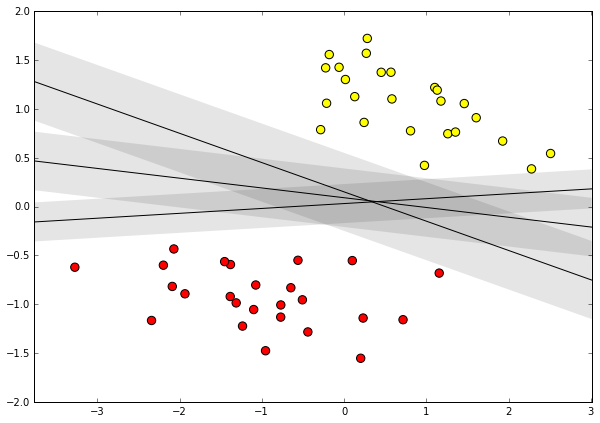

In [2]:
from sklearn.datasets.samples_generator import make_classification
X, y = make_classification(n_samples=50, n_features=2, n_informative=2, 
                            n_redundant=0, n_clusters_per_class=1, random_state=0)
x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')

for a, b, w in [(-0.1, 0.09, 0.3), (0.05, 0.03, 0.2), (-0.3, 0.15, 0.4)]:
    y_line = a * x_line + b
    plt.plot(x_line, y_line, '-k')
    plt.fill_between(x_line, y_line - w, y_line + w, edgecolor='none', color='k', alpha=0.1)
plt.xlim(x_line[0], x_line[-1])
plt.show()

Обучим линейный SVM и отобразим результат на рисунке. Выделенные объекты называются *опорными векторами* - они лежат на границе разделяющей полосы.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


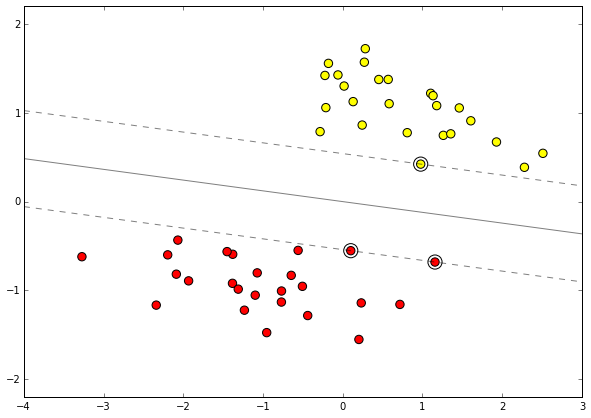

In [3]:
from sklearn.svm import SVC

def plot_svc_decision_function(clf, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

# Fitting linear SVM model
lin_svm = SVC(kernel='linear', C=10).fit(X, y)

# Plotting the splitting hyperplane and support vectors
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
plot_svc_decision_function(lin_svm)
plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
plt.xlim(-4, 3)
plt.show()

Рассмотрим теперь случай, когда выборка не является линейно разделимой. Типичный примеры - это концентрические окружности. Обучим линейный SVM и посмотрим на результат.

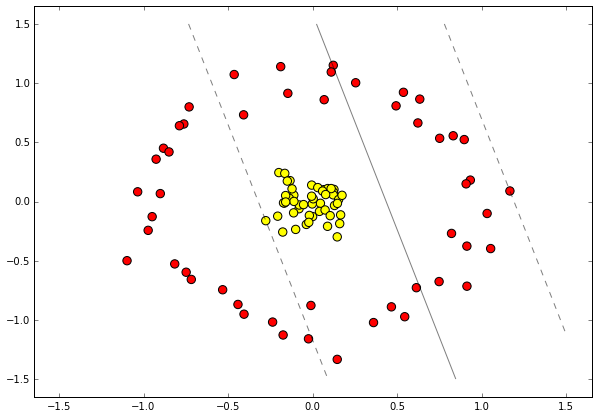

In [4]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(n_samples=100, factor=0.1, 
                    noise=0.1, random_state=0)

lin_svm = SVC(kernel='linear').fit(X, y)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
plot_svc_decision_function(lin_svm)
plt.show()

## Kernel trick

Как видно, линейные разделяющие поверхности никак не могут дать хорошего качества классификации, в случае такой явно выраженной линейной неразделимости. Напомним, что переход к двойственной задаче оптимизации в алгоритме SVM позволил переписать решающую функцию как сумму скалярных произведений объектов с некоторыми коэффициентами. Заменяя эти скалярные произведения $\langle x_i, x_i \rangle$ на ядровую функцию $K(x_i, x_j) = \langle \varphi(x_i), \varphi(x_j) \rangle$, которая представляет собой скалярное произведение образов исходных объектов в некотором пространстве большей размерности, мы получаем возможность строить более сложные разделяющие поверхности в исходном пространстве. 

Стоит отметить, вычисление значений $K(x_i, x_j)$ может быть сильно упрощено и оптимизировано во многих важных частных случаях, и реализация SVM в sklearn использует такие трюки. Например, в случае полиномиального ядра степени 2, для вычисления значения $K(x_i, x_j)$ не нужно сначала вычислять образы $\varphi(x_i), \varphi(x_j)$, используя формулу:

<center>
<img src="https://upload.wikimedia.org/math/1/5/7/157b3f647240fdce86ca1c96c55943f2.png">
</center>

а затем вычислять скалярное произведение этих векторов в новом пространстве большей размерности. Достаточно вычислить значение $K(x_i, x_j) = (\langle x_i, x_j \rangle + c)^2$. Таким образом, для основных ядер вычисление значения $K(x_i, x_j)$ сводится к вычислению скалярных произведений в исходном (маломерном) пространстве, что позволяет избежать вычисления преобразования $\varphi(x)$ и существенно ускоряет работу алгоритма.

Указанная выше выборка может быть линейно разделена в пространстве размерности 3. Переход туда можно осуществить многими способами. Для начала рассмотрим использование полиномиального ядра степени 2. Ниже приведён образ выборки в трёхмерном пространстве. Видно, что в новом пространстве выборка может быть легко разделена с помощью плоскости.

<function __main__.plot_3D>

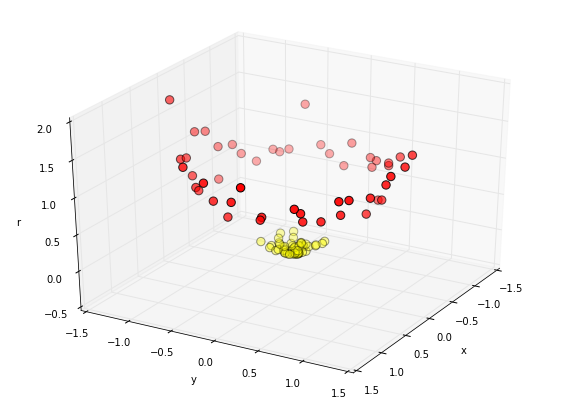

In [5]:
from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

r = X[:, 0] ** 2 + X[:, 1] ** 2

def plot_3D(elev=30, azim=30):
    plt.figure(figsize=(10,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180))

Обучим SVM с полиномиальным ядром степени 2 и посмотрим на результат его работы в исходном пространстве. Получаем безошибочное разделение выборки на два класса. Заметим, что опорные объекты уже необязательно лежат на границе разделяющей полосы, в отличие от случая линейно разделимой выборки.

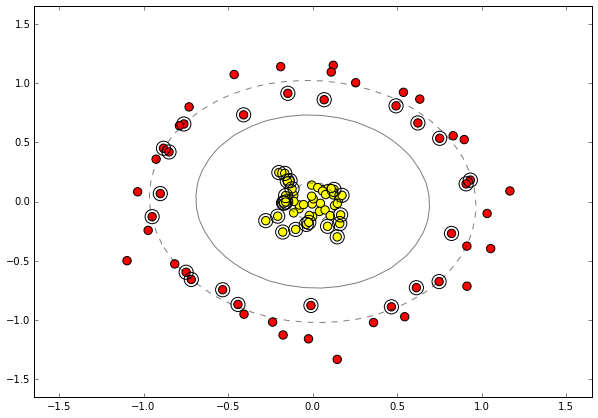

In [6]:
poly_svm = SVC(kernel='poly', degree=2).fit(X, y)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
plot_svc_decision_function(poly_svm)
plt.scatter(poly_svm.support_vectors_[:, 0], poly_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
plt.show()

Второй способ вложения исходной выборки в трёхмерное пространство использует так называемое RBF-ядро (от radial basis functions). Посмотрим на результат этого вложения:

<function __main__.plot_3D>

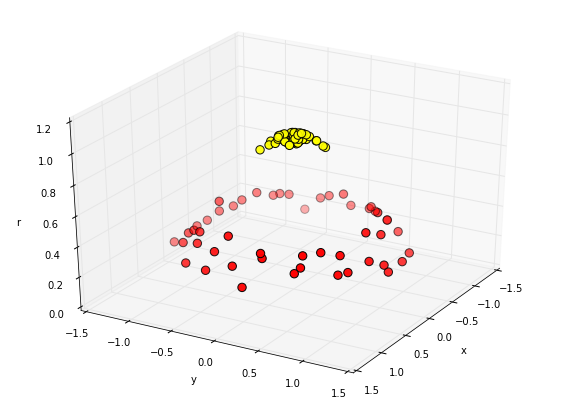

In [7]:
re = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

def plot_3D(elev=30, azim=30):
    plt.figure(figsize=(10,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], re, c=y, s=70, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180))

Обучим SVM с RBF-ядром и посмотрим на результат его работы в исходном пространстве. Также как и в случае полиномиального ядра получаем безошибочную классификацию.

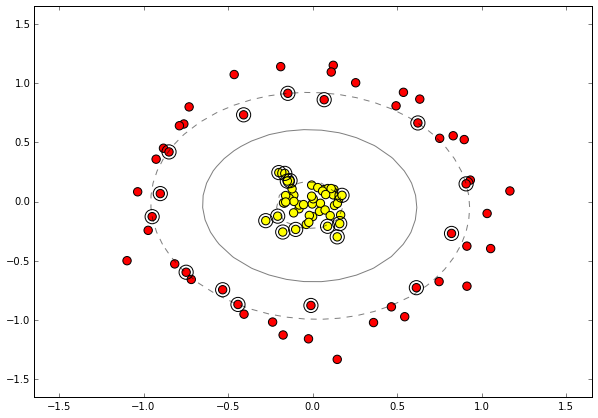

In [8]:
rbf_svm = SVC(kernel='rbf').fit(X, y)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
plot_svc_decision_function(rbf_svm)
plt.scatter(rbf_svm.support_vectors_[:, 0], rbf_svm.support_vectors_[:, 1],
            s=200, facecolors='none');
plt.show()

RBF-ядро позволяет строить значительно более сложные поверхности по сравнению с полиномиальным ядром (поскольку формально происходит переход в бесконечномерное пространство), однако это может стать причиной переобучения. Чтобы избежать его, необходимо правильно подбирать параметры ядра. Посмотрим на поведение разделяющей поверхности при изменении объёма выборки, а также при изменении параметра $\gamma$:

<function __main__.plot_svm>

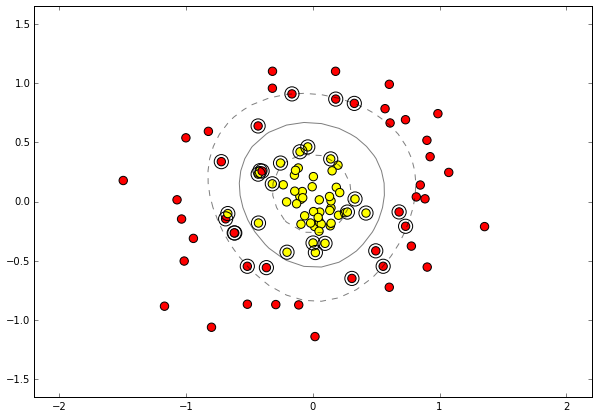

In [9]:
def plot_svm(N=100, gamma=0.0):
    X, y = make_circles(n_samples=200, factor=0.1, 
                        noise=0.2, random_state=0)
    X, y = X[:N], y[:N]
    rbf = SVC(kernel='rbf', gamma=0.1**gamma).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(rbf, plt.gca())
    plt.scatter(rbf.support_vectors_[:, 0], rbf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], gamma=[-3.0, 1.0])

## Полезные ссылки
- SVM: [wiki](https://en.wikipedia.org/wiki/Support_vector_machine) и [machinelearning](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%B0_%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2)
- [Kernel trick](https://en.wikipedia.org/wiki/Kernel_method)